# [examples](http://www.nest-simulator.org/more-example-networks/)

* [balanced neuron example](http://www.nest-simulator.org/py_sample/balancedneuron/)

This script simulates a neuron driven by an excitatory and an inhibitory population of neurons firing Poisson spike trains. The aim is to find a firing rate for the inhibitory population that will make the neuron fire at the same rate as the excitatory population

In [1]:
from scipy.optimize import bisect
import nest
import nest.voltage_trace
nest.set_verbosity("M_WARNING") # to suppress info messages
nest.ResetKernel()


# simulation parameters

t_sim = 25000.0  # how long we simulate
n_ex = 16000     # size of the excitatory population
n_in = 4000      # size of the inhibitory population
r_ex = 5.0       # mean rate of the excitatory population
r_in = 20.5      # initial rate of the inhibitory population
epsc = 45.0      # peak amplitude of excitatory synaptic currents
ipsc = -45.0     # peak amplitude of inhibitory synaptic currents
d = 1.0          # synaptic delay
lower = 15.0     # lower bound of the search interval
upper = 25.0     # upper bound of the search interval
prec = 0.01      # how close need the excitatory rates be


#create nodes (nodes voltmeters, spikedetectors)

neuron = nest.Create("iaf_psc_alpha")
noise = nest.Create("poisson_generator", 2)
voltmeter = nest.Create("voltmeter")
spikedetector = nest.Create("spike_detector")

nest.SetStatus(noise, [{"rate": n_ex * r_ex}, 
                       {"rate": n_in * r_in}])

# voltmeter configuration
nest.SetStatus(voltmeter, {"withgid": True, "withtime": True})


# Note that the connection direction for the voltmeter is
# reversed compared to the spike_detector, because it 
# observes the neuron instead of receiving events from it.

nest.Connect(neuron, spikedetector)
nest.Connect(voltmeter, neuron)
nest.Connect(noise, neuron, 
             syn_spec={'weight': [[epsc, ipsc]], 'delay': 1.0})


# function output_rate is defined to measure the firing rate
# of the target neuron for a given rate of the inhibitory neurons

def output_rate(guess):
    print("Inhibitory rate estimate: %5.2f Hz" % guess)
    rate = float(abs(n_in * guess))
    nest.SetStatus([noise[1]], "rate", rate)
    nest.SetStatus(spikedetector, "n_events", 0)
    nest.Simulate(t_sim)
    out = nest.GetStatus(spikedetector, "n_events")[0] * 1000.0 / t_sim
    print("  -> Neuron rate: %6.2f Hz (goal: %4.2f Hz)" % (out, r_ex))
    return out

The function takes the firing rate of the inhibitory neurons as an argument. It scales the rate with the size of the inhibitory population and configures the inhibitory Poisson generator (noise[1]) accordingly. Then, the spike counter of the spike_detector is reset to zero. The network is simulated using Simulate, which takes the desired simulation time in milliseconds and advances the network state by this amount of time. During simulation, the spike_detector counts the spikes of the target neuron and the total number is read out at the end of the simulation period. The return value of output_rate() is the firing rate of the target neuron in Hz.

Second, the scipy function bisect is used to determine the optimal firing rate of the neurons of the inhibitory population.

In [4]:
in_rate = bisect(lambda x: output_rate(x) - r_ex, lower, upper, xtol=prec)
# arguments:
# f(x) whose zero crossing is to be determined,
# lower and upper bound of the interval in which to search for the zero crossing
# desired relative precision of the zero crossing.

print("Optimal rate for the inhibitory population: %.2f Hz" % in_rate)

Inhibitory rate estimate: 15.00 Hz
  -> Neuron rate: 347.76 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 25.00 Hz
  -> Neuron rate:   0.04 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.00 Hz
  -> Neuron rate:  35.28 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 22.50 Hz
  -> Neuron rate:   0.04 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 21.25 Hz
  -> Neuron rate:   0.52 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.62 Hz
  -> Neuron rate:   8.56 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.94 Hz
  -> Neuron rate:   3.04 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.78 Hz
  -> Neuron rate:   5.44 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.86 Hz
  -> Neuron rate:   4.56 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.82 Hz
  -> Neuron rate:   4.24 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.80 Hz
  -> Neuron rate:   5.56 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.81 Hz
  -> Neuron rate:   4.64 Hz (goal: 5.00 Hz)
Optimal rate for the inhibitory population: 20.81 Hz

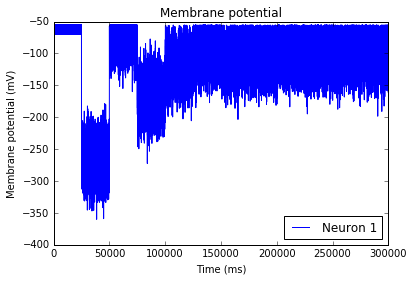

In [3]:
nest.voltage_trace.from_device(voltmeter);


### [Nest by examples](http://www.nest-simulator.org/wp-content/uploads/2015/02/NEST_by_Example.pdf)
-  A sparsely connected recurrent network


In [6]:
import nest
import nest.raster_plot
import pylab as pl 

nest.ResetKernel()

g = 5.0          # ratio inhibitory weight/excitatory weight
eta = 2.0        # external rate relative to threshold rate
delay = 1.5 
tau_m = 20.0 
V_th = 20.0 
N_E = 8000 
N_I = 2000
N_neurons = N_E + N_I
C_E = int(N_E / 10)
C_I = int(N_I / 10) 
J_E = 0.1 
J_I = -g * J_E
nu_ex = eta * V_th / (J_E * C_E * tau_m)
p_rate = 1000.0 * nu_ex * C_E

nest.SetKernelStatus({'print_time': True}) # print progress time in terminal

# Creating neurons and devices



In [1]:
# brunel_delta_nest.py
'''
Random balanced network (delta synapses)
----------------------------------------

This script simulates an excitatory and an inhibitory population on
the basis of the network used in

Brunel N, Dynamics of Sparsely Connected Networks of Excitatory and
Inhibitory Spiking Neurons, Journal of Computational Neuroscience 8,
183-208 (2000).

When connecting the network customary synapse models are used, which
allow for querying the number of created synapses. Using spike
detectors the average firing rates of the neurons in the populations
are established. The building as well as the simulation time of the
network are recorded.
'''


# Import all necessary modules for simulation, analysis and plotting.


import nest
import nest.raster_plot

import time
from numpy import exp

nest.ResetKernel()


# Assigning the current time to a variable in order to determine the
# build time of the network.


startbuild = time.time()


# Assigning the simulation parameters to variables.


dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5  # synaptic delay in ms


# Definition of the parameters crucial for asynchronous irregular firing
# of the neurons.


g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability


# Definition of the number of neurons in the network and the number of
# neuron recorded from

order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons


# Definition of connectivity parameter


CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)    # total number of synapses per neuron


# Initialization of the parameters of the integrate and fire neuron and
# the synapses. The parameter of the neuron are stored in a dictionary.


tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

'''
Definition of threshold rate, which is the external rate needed to fix
the membrane potential around its threshold, the external firing rate
and the rate of the poisson generator which is multiplied by the
in-degree CE and converted to Hz by multiplication by 1000.
'''

nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

'''
Configuration of the simulation kernel by the previously defined time
resolution used in the simulation. Setting "print_time" to True prints
the already processed simulation time as well as its percentage of the
total simulation time.
'''

nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

'''
Configuration of the model `iaf_psc_delta` and `poisson_generator`
using SetDefaults(). This function expects the model to be the
inserted as a string and the parameter to be specified in a
dictionary. All instances of theses models created after this point
will have the properties specified in the dictionary by default.
'''

nest.SetDefaults("iaf_psc_delta", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

'''
Creation of the nodes using `Create`. We store the returned handles in
variables for later reference. Here the excitatory and inhibitory, as
well as the poisson generator and two spike detectors. The spike
detectors will later be used to record excitatory and inhibitory
spikes.
'''

nodes_ex = nest.Create("iaf_psc_delta", NE)
nodes_in = nest.Create("iaf_psc_delta", NI)
noise = nest.Create("poisson_generator")
espikes = nest.Create("spike_detector")
ispikes = nest.Create("spike_detector")

'''
Configuration of the spike detectors recording excitatory and
inhibitory spikes using `SetStatus`, which expects a list of node
handles and a list of parameter dictionaries. Setting the variable
"to_file" to True ensures that the spikes will be recorded in a .gdf
file starting with the string assigned to label. Setting "withtime"
and "withgid" to True ensures that each spike is saved to file by
stating the gid of the spiking neuron and the spike time in one line.
'''

nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

print("Connecting devices")

'''
Definition of a synapse using `CopyModel`, which expects the model
name of a pre-defined synapse, the name of the customary synapse and
an optional parameter dictionary. The parameters defined in the
dictionary will be the default parameter for the customary
synapse. Here we define one synapse for the excitatory and one for the
inhibitory connections giving the previously defined weights and equal
delays.
'''

nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

'''
Connecting the previously defined poisson generator to the excitatory
and inhibitory neurons using the excitatory synapse. Since the poisson
generator is connected to all neurons in the population the default
rule ('all_to_all') of Connect() is used. The synaptic properties are
inserted via syn_spec which expects a dictionary when defining
multiple variables or a string when simply using a pre-defined
synapse.
'''

nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

'''
Connecting the first N_rec nodes of the excitatory and inhibitory
population to the associated spike detectors using excitatory
synapses. Here the same shortcut for the specification of the synapse
as defined above is used.
'''

nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

'''
Connecting the excitatory population to all neurons using the
pre-defined excitatory synapse. Beforehand, the connection parameter
are defined in a dictionary. Here we use the connection rule
'fixed_indegree', which requires the definition of the indegree. Since
the synapse specification is reduced to assigning the pre-defined
excitatory synapse it suffices to insert a string.
'''

conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

'''
Connecting the inhibitory population to all neurons using the
pre-defined inhibitory synapse. The connection parameter as well as
the synapse paramtere are defined analogously to the connection from
the excitatory population defined above.
'''

conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

'''
Storage of the time point after the buildup of the network in a
variable.
'''

endbuild = time.time()

'''
Simulation of the network.
'''

print("Simulating")

nest.Simulate(simtime)

'''
Storage of the time point after the simulation of the network in a
variable.
'''

endsimulate = time.time()

'''
Reading out the total number of spikes received from the spike
detector connected to the excitatory population and the inhibitory
population.
'''

events_ex = nest.GetStatus(espikes, "n_events")[0]
events_in = nest.GetStatus(ispikes, "n_events")[0]

'''
Calculation of the average firing rate of the excitatory and the
inhibitory neurons by dividing the total number of recorded spikes by
the number of neurons recorded from and the simulation time. The
multiplication by 1000.0 converts the unit 1/ms to 1/s=Hz.
'''

rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

'''
Reading out the number of connections established using the excitatory
and inhibitory synapse model. The numbers are summed up resulting in
the total number of synapses.
'''

num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

'''
Establishing the time it took to build and simulate the network by
taking the difference of the pre-defined time variables.
'''

build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

'''
Printing the network properties, firing rates and building times.
'''

print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory rate   : %.2f Hz" % rate_ex)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

'''
Plot a raster of the excitatory neurons and a histogram.
'''

nest.raster_plot.from_device(espikes, hist=True);


Building network
Connecting devices
Connecting network
Excitatory connections
Inhibitory connections
Simulating
Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory rate   : 31.86 Hz
Inhibitory rate   : 32.02 Hz
Building time     : 7.11 s
Simulation time   : 44.17 s
